## Portfolio Optimization Using Modern Portfolio Theory

#### Description
This notebook utilizes OpenBB’s data for portfolio optimization based on MPT principles. We would be optimizing a portfolio of top 10 crypto assets, using the daily close data from 1st october 2023 to 1st october 2024.

The portfolio optimization would be done using the mean-variance approach. The mean-variance approach helps determine the optimal allocation of assets in a portfolio to minimize overall risk while maximizing expected returns.

#### Author
[Ambrose Ikpele](https://github.com/ambroseikpele)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenBB-Finance/OpenBB/blob/develop/examples/[Notebook_Name].ipynb)

### Introduction

Modern Portfolio Theory (MPT) is a mathematical framework for constructing a portfolio of assets to maximize expected return based on a given level of risk. In this notebook, we will implement MPT to construct an optimal portfolio with minimum volatility using a selection of the top cryptocurrencies as our assets. The notebook will fetch historical price data for these assets, calculate the portfolio's expected return and risk, and visualize the optimal portfolio based on risk-return trade-offs.

Install external packages

In [17]:
!pip install openbb
!pip install PyPortfolioOpt

Import necessary packages

In [1]:
from openbb import obb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypfopt import EfficientFrontier
from pypfopt import CovarianceShrinkage, CLA, expected_returns

### Define the assets and fetch the data

Fetch the daily data of the top crypto currencies for a period of one year using openbb

In [2]:
top_crypto= ['ADA-USD', 'BNB-USD', 'BTC-USD', 'DOT-USD', 'ETH-USD', 'LTC-USD','MATIC-USD', 'SOL-USD', 'TRX-USD', 'XRP-USD']

ohlc_data= obb.crypto.price.historical(top_crypto, provider="yfinance", interval='1d', start_date='2023-10-01', end_date='2024-10-01').to_df()
ohlc_data

,open,high,low,close,volume,symbol
date,,,,,,
2023-10-01,0.254043,0.267471,0.254019,0.265895,1.650882e+08,ADA-USD
2023-10-01,214.800323,219.133835,213.506516,218.047134,3.874081e+08,BNB-USD
2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,9.503917e+09,BTC-USD
2023-10-01,4.105477,4.279937,4.103880,4.261009,8.294334e+07,DOT-USD
2023-10-01,1671.161499,1750.595703,1670.082153,1733.810425,5.054880e+09,ETH-USD
...,...,...,...,...,...,...
2024-09-30,69.314308,69.321297,66.454277,66.820450,3.003743e+08,LTC-USD
2024-09-30,0.421419,0.421627,0.394318,0.395917,3.730373e+07,MATIC-USD
2024-09-30,158.632416,159.508926,152.019836,152.618469,2.376781e+09,SOL-USD


Select the close data from ohlc_data for each crypto currency

In [3]:
close_symbol= ohlc_data[['close', 'symbol']]

# Setting the symbol as the second index level
close_symbol = close_symbol.set_index('symbol', append= True)

# Unstack 'symbol' to make each unique symbol a separate column
close_symbol_unstacked= close_symbol.unstack(level='symbol')

# Flatten the column headers
close_symbol_unstacked.columns = close_symbol_unstacked.columns.get_level_values(1)

prices= close_symbol_unstacked

prices

symbol,ADA-USD,BNB-USD,BTC-USD,DOT-USD,ETH-USD,LTC-USD,MATIC-USD,SOL-USD,TRX-USD,XRP-USD
date,,,,,,,,,,
2023-10-01,0.265895,218.047134,27983.750000,4.261009,1733.810425,68.233315,0.568532,23.836487,0.090118,0.524204
2023-10-02,0.259513,214.757935,27530.785156,4.123762,1663.627563,66.011124,0.547513,23.371700,0.087566,0.512832
2023-10-03,0.261028,213.435944,27429.978516,4.074247,1656.685669,65.493515,0.566308,23.552694,0.090858,0.538387
2023-10-04,0.259315,213.413086,27799.394531,4.047316,1647.838135,64.452065,0.563369,23.144787,0.088999,0.532931
2023-10-05,0.260149,210.679672,27415.912109,4.022738,1611.476440,64.858765,0.546018,22.694141,0.088276,0.523366
...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.401882,596.776917,65181.019531,4.816284,2632.199951,68.518311,0.424973,155.576096,0.153201,0.590421
2024-09-27,0.402328,607.867004,65790.664062,4.892055,2695.900635,71.188202,0.433774,157.749939,0.155170,0.588927
2024-09-28,0.401052,601.567200,65887.648438,4.805896,2677.539062,70.003967,0.423559,156.912430,0.155068,0.614801


### Calculate Portfolio's Expected Returns

The expected returns serve as the basis for evaluating different asset combinations and determining the optimal portfolio allocation. In the next steps, these returns will be used along with the covariance matrix to analyze risk-return profiles.

$$return=\frac{Σ\space r_{i}}{N}⋅365$$

where $r_i$ is the daily return of a particular asset and $N$ is the number of days in the data, we multiply by 365 so as to annualize the result

In [4]:
# Expected returns of crypto assets using the mean historical return.
assets_expected_returns = expected_returns.mean_historical_return(prices, frequency=365, compounding=False)
assets_expected_returns

,0
symbol,
ADA-USD,0.604022
BNB-USD,1.121563
BTC-USD,0.952337
DOT-USD,0.319752
ETH-USD,0.591286
LTC-USD,0.173647
MATIC-USD,-0.058596
SOL-USD,2.288214
TRX-USD,0.616572


The frequency parameter indicates the number of trading periods in a year. For crypto daily data, it is set to 365, since crypto can be traded everyday.

The compounding parameter calculate returns using simple or compounded growth. Setting compounding=False results in simple annualized returns. If compounding=True, the function would compute geometric (compounded) returns, which consider reinvested returns over time.

### Calculate the Covariance Matrix Using the Ledoit-Wolf Shrinkage Estimator

The covariance matrix represents the relationship between the returns of the assets. It measures how returns of one asset(e.g btc) vary in relation to another(e.g eth), which is essential for understanding the overall risk of a portfolio. Assets with high positive covariance tend to move in the same direction, while those with negative covariance move in opposite directions.

The formula below uses an example of btc and eth to express how covariance is calculated:

$$Cov({r_{btc}, r_{eth} })= \frac{Σ(r_{btc}-\bar r_{btc})(r_{eth}-\bar r_{eth})}{N}$$

Where $r$ is the daily returns of the assets and $\bar r$ is the average daily returns of the assets.

In [5]:
# Covariance matrix of crypto assets using the Ledoit-Wolf shrinkage method.
covariance = CovarianceShrinkage(prices).ledoit_wolf()
covariance

symbol,ADA-USD,BNB-USD,BTC-USD,DOT-USD,ETH-USD,LTC-USD,MATIC-USD,SOL-USD,TRX-USD,XRP-USD
symbol,,,,,,,,,,
ADA-USD,0.366706,0.150286,0.180182,0.304589,0.203891,0.205121,0.278896,0.297128,0.083817,0.194349
BNB-USD,0.150286,0.231405,0.122723,0.150846,0.139246,0.109135,0.173927,0.172109,0.047007,0.093584
BTC-USD,0.180182,0.122723,0.190093,0.176476,0.172781,0.127462,0.170640,0.222148,0.055094,0.120736
DOT-USD,0.304589,0.150846,0.176476,0.386458,0.207296,0.193352,0.288592,0.333958,0.086146,0.192491
ETH-USD,0.203891,0.139246,0.172781,0.207296,0.259972,0.160428,0.225087,0.232898,0.063453,0.133452
LTC-USD,0.205121,0.109135,0.127462,0.193352,0.160428,0.270809,0.191384,0.191960,0.055784,0.158367
MATIC-USD,0.278896,0.173927,0.170640,0.288592,0.225087,0.191384,0.415755,0.290945,0.075620,0.181063
SOL-USD,0.297128,0.172109,0.222148,0.333958,0.232898,0.191960,0.290945,0.595302,0.095612,0.185187
TRX-USD,0.083817,0.047007,0.055094,0.086146,0.063453,0.055784,0.075620,0.095612,0.098694,0.057615


**Ledoit-Wolf Shrinkage**:is a technique used to improve the estimation of covariance matrices, especially when dealing with high-dimensional data (like multiple crypto assets) relative to the number of observations.

### Portfolio Optimization using Critical Line Algorithm (CLA)

Portfolio risk, also known as portfolio volatility, is determined by calculating the variance of the returns of the assets. The variance is calculated using the below equation:

$$ \sigma^2= W⋅Cov⋅W^T $$

Where $W$ is the weights of the asstes and $Cov$ is the covariance of the returns of the assets in the portfolio.

**The Critical Line Algorithm (CLA)** optimizes asset weights in a portfolio by calculating the risk and expected return for various combinations of these weights. It systematically varies the weights assigned to each asset, assessing how each combination affects overall portfolio performance. This process helps identify efficient portfolios that maximize expected returns for a given level of risk or minimize risk for a desired return.

In [6]:
# Create a Critical Line Algorithm (CLA) object using the calculated expected returns and covariance matrix.
cla = CLA(assets_expected_returns, covariance)

**The Efficient Frontier** is a curve showing optimal portfolios with the best risk-return tradeoffs. It's important because it helps us identify portfolios that maximize return for a given risk level or minimize risk for a desired return.

In [7]:
# Calculate the efficient frontier, obtaining the returns, volatility, and weights for various portfolios.
(returns, volatility, weights) = cla.efficient_frontier()

efficient_frontier_portfolios= pd.DataFrame([returns, volatility, weights]).T
efficient_frontier_portfolios.columns=['returns', 'volatility', 'weights']

efficient_frontier_portfolios

,returns,volatility,weights
0,2.288214,0.771558,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
1,2.288214,0.771558,"[[0.0], [8.540177112501205e-18], [0.0], [0.0],..."
2,2.288214,0.771558,"[[0.0], [1.708035422500241e-17], [0.0], [0.0],..."
3,2.288214,0.771558,"[[0.0], [2.5620531337503614e-17], [0.0], [0.0]..."
4,2.288214,0.771558,"[[0.0], [3.416070845000482e-17], [0.0], [0.0],..."
...,...,...,...
74,0.699686,0.289411,"[[0.0], [0.14064237710852637], [0.110488877515..."
75,0.695988,0.289372,"[[0.0], [0.1384244599412712], [0.1077026598376..."
76,0.692291,0.289344,"[[0.0], [0.136206542774016], [0.10491644215937..."
77,0.688593,0.289328,"[[0.0], [0.1339886256067608], [0.1021302244811..."


### Visualize the efficient frontier

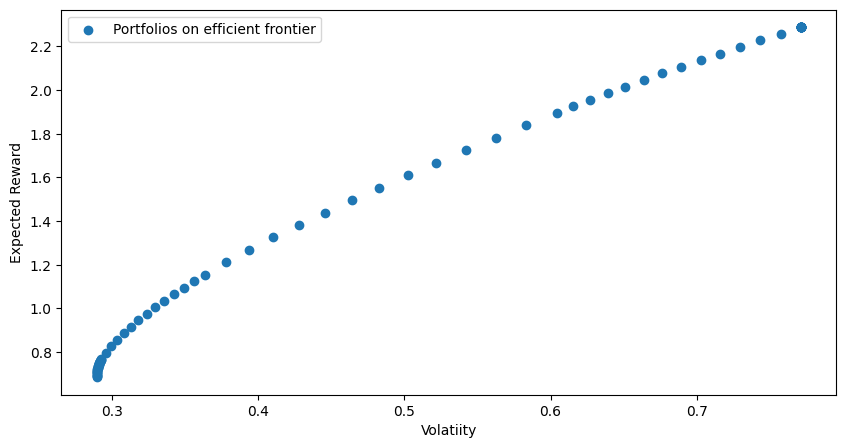

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(volatility, returns, label='Portfolios on efficient frontier')
plt.legend()
plt.ylabel('Expected Reward')
plt.xlabel('Volatiity')
plt.show()

Get the weights (in perentage) of the portfolio with the lowest volatility

In [9]:
optimized_weight=np.array(list(cla.max_sharpe().values()))
optimized_weight= np.round(optimized_weight, 4)

pie_df=pd.DataFrame(optimized_weight*100, index=prices.columns, columns=['weights'])
pie_df= pie_df.sort_values(by=['weights'], ascending=False)
pie_df

,weights
symbol,
SOL-USD,37.11
TRX-USD,32.71
BNB-USD,30.17
ADA-USD,0.00
BTC-USD,-0.00
DOT-USD,0.00
ETH-USD,0.00
LTC-USD,0.00
MATIC-USD,0.00


Display Pie Chart of the weights

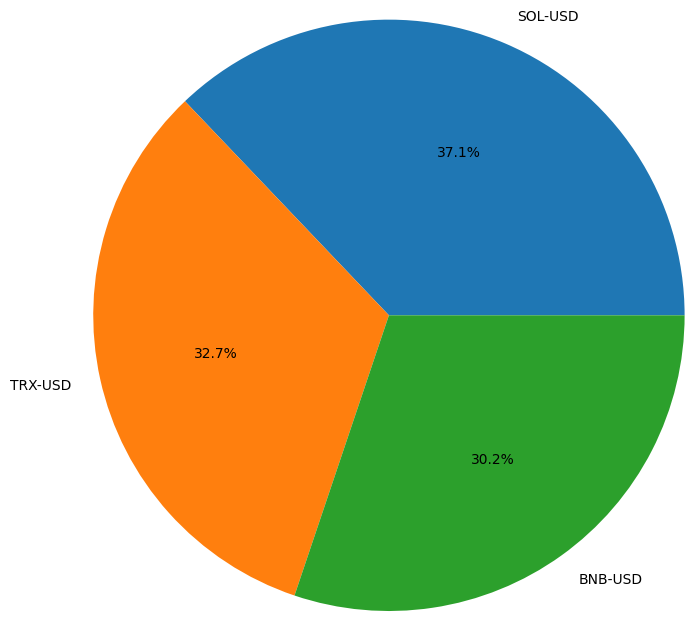

In [10]:
pie_df= pie_df.query('weights != 0.000000')

fig, ax = plt.subplots()
ax.pie(pie_df.weights, labels=pie_df.index.values.tolist(), autopct='%1.1f%%', radius=2)
plt.show()

The above weights forms a portfolio with maximum sharpe ratio